In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 機械学習関連のライブラリ
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [30]:
# CSVファイルの読み込み
df = pd.read_csv('../data/bybit_btcusdt_20231001-20240930.csv',index_col=0)

# 'Timestamp'列を日時型に変換し、インデックスに設定
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# データの確認
print(df.head())

                        Open     High      Low    Close  Volume
Timestamp                                                      
2023-09-30 15:00:00  26983.4  26986.6  26983.4  26986.6   6.216
2023-09-30 15:01:00  26986.6  26991.6  26986.6  26991.6  26.141
2023-09-30 15:02:00  26991.6  26992.0  26990.3  26992.0  30.235
2023-09-30 15:03:00  26992.0  26992.0  26983.4  26983.4  15.045
2023-09-30 15:04:00  26983.4  26983.4  26971.6  26975.3  74.219


In [31]:
# 特徴量の計算
# 移動平均線（短期・長期）
df['MA_short'] = df['Close'].rolling(window=5).mean()
df['MA_long'] = df['Close'].rolling(window=20).mean()

# ボリンジャーバンド
df['Middle_Band'] = df['Close'].rolling(window=20).mean()
df['STD'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['Middle_Band'] + (df['STD'] * 2)
df['Lower_Band'] = df['Middle_Band'] - (df['STD'] * 2)

# RSIの計算（14期間）
delta = df['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACDの計算
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 出来高変化率
df['Volume_Change'] = df['Volume'].pct_change()

# 価格変化率
df['Price_Change'] = df['Close'].pct_change()

# ストキャスティクスの計算
df['Lowest_Low'] = df['Low'].rolling(window=14).min()
df['Highest_High'] = df['High'].rolling(window=14).max()
df['Stochastic_%K'] = (df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low']) * 100
df['Stochastic_%D'] = df['Stochastic_%K'].rolling(window=3).mean()

# CCI（Commodity Channel Index）の計算
TP = (df['High'] + df['Low'] + df['Close']) / 3  # Typical Price
df['CCI'] = (TP - TP.rolling(window=20).mean()) / (0.015 * TP.rolling(window=20).std())

# ATR（Average True Range）の計算（既にATRを計算している場合はスキップ）
# True Rangeの計算
df['High_Low'] = df['High'] - df['Low']
df['High_Close'] = abs(df['High'] - df['Close'].shift(1))
df['Low_Close'] = abs(df['Low'] - df['Close'].shift(1))
df['True_Range'] = df[['High_Low', 'High_Close', 'Low_Close']].max(axis=1)

# ATRの計算（14期間）
df['ATR'] = df['True_Range'].rolling(window=14).mean()

# ATRバンドの計算
df['ATR_Upper'] = df['Close'] + (df['ATR'] * 2)
df['ATR_Lower'] = df['Close'] - (df['ATR'] * 2)

# ラグ特徴量の追加（例として、1分、5分、10分前のRSI）
df['RSI_Lag1'] = df['RSI'].shift(1)
df['RSI_Lag5'] = df['RSI'].shift(5)
df['RSI_Lag10'] = df['RSI'].shift(10)

# 交互作用項の追加（MACDと出来高変化率の掛け算）
df['MACD_Volume'] = df['MACD'] * df['Volume_Change']

# トレンドの傾きの計算（短期移動平均線の傾き）
df['MA_short_Slope'] = df['MA_short'].diff()

# OBV（On-Balance Volume）の計算
df['Direction'] = np.where(df['Close'] > df['Close'].shift(1), 1, -1)
df['OBV'] = (df['Volume'] * df['Direction']).cumsum()

# パーセンテージ変動率の計算
df['Pct_Volatility'] = (df['High'] - df['Low']) / df['Close'] * 100

# 価格の相対的な位置情報の計算（一定期間内の価格位置）
rolling_window = 20  # 例として20期間
df['Rolling_Max'] = df['High'].rolling(window=rolling_window).max()
df['Rolling_Min'] = df['Low'].rolling(window=rolling_window).min()
df['Price_Position'] = (df['Close'] - df['Rolling_Min']) / (df['Rolling_Max'] - df['Rolling_Min'])

# 不要な一時的な列を削除
df.drop(['Lowest_Low', 'Highest_High', 'High_Low', 'High_Close', 'Low_Close', 'True_Range', 'Direction', 'Rolling_Max', 'Rolling_Min'], axis=1, inplace=True)


# 欠損値の削除
df.dropna(inplace=True)

# 特徴量の確認
print(df.head())

                        Open     High      Low    Close  Volume  MA_short  \
Timestamp                                                                   
2023-09-30 15:23:00  27035.9  27036.0  27028.7  27028.8  16.357  27031.48   
2023-09-30 15:24:00  27028.8  27028.8  27028.5  27028.6   7.348  27031.88   
2023-09-30 15:25:00  27028.6  27033.6  27026.8  27033.0  26.986  27032.70   
2023-09-30 15:26:00  27033.0  27033.1  27025.1  27025.2  19.555  27030.30   
2023-09-30 15:27:00  27025.2  27025.2  27003.3  27003.4  86.890  27023.80   

                       MA_long  Middle_Band        STD    Upper_Band  ...  \
Timestamp                                                             ...   
2023-09-30 15:23:00  27012.140    27012.140  23.933293  27060.006587  ...   
2023-09-30 15:24:00  27014.805    27014.805  22.542299  27059.889598  ...   
2023-09-30 15:25:00  27017.640    27017.640  20.954371  27059.548743  ...   
2023-09-30 15:26:00  27020.055    27020.055  18.670818  27057.396636  ...  

In [32]:
# 目的変数の設定
# 将来の期間（例: 5分後）
future_window = 5

# 閾値の設定
upper_threshold = 0.001  # +0.1%
lower_threshold = -0.001  # -0.1%

# 将来5分間の最高値と最安値を計算
df['Future_Max'] = df['High'].rolling(window=future_window).max().shift(-future_window)
df['Future_Min'] = df['Low'].rolling(window=future_window).min().shift(-future_window)

# 可能な最大利益と最大損失を計算
df['Max_Profit'] = (df['Future_Max'] - df['Close']) / df['Close']
df['Max_Loss'] = (df['Future_Min'] - df['Close']) / df['Close']

# 目的変数を設定（クラスラベルを0, 1, 2に変更）
def profit_label(row):
    if row['Max_Profit'] > upper_threshold:
        return 2  # 買いシグナル
    elif row['Max_Loss'] < lower_threshold:
        return 0  # 売りシグナル
    else:
        return 1  # ホールド

df['Target'] = df.apply(profit_label, axis=1)

# 目的変数の分布を確認
print(df['Target'].value_counts())

1    211714
2    177214
0    137523
Name: Target, dtype: int64


In [33]:
# モデルの学習
# 説明変数の選択（追加した特徴量を含める）
features = [
    'MA_short', 'MA_long', 'Upper_Band', 'Lower_Band', 'RSI', 'MACD', 'Signal_Line',
    'Volume_Change', 'Price_Change',
    'Stochastic_%K', 'Stochastic_%D', 'CCI', 'ATR', 'ATR_Upper', 'ATR_Lower',
    'RSI_Lag1', 'RSI_Lag5', 'RSI_Lag10',
    'MACD_Volume', 'MA_short_Slope', 'OBV', 'Pct_Volatility', 'Price_Position'
]

# データの準備
X = df[features]
y = df['Target']

# データを訓練用とテスト用に分割（時系列データなのでシャッフルしない）
split_ratio = 0.7
split_index = int(len(df) * split_ratio)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 特徴量の標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ハイパーパラメータのチューニングとモデルの訓練（前回のコードを使用）
# 必要なライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# ハイパーパラメータのチューニング用のパラメータグリッドを定義（変更可能）
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

# 時系列データ用のクロスバリデーション
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost分類器の初期化
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# GridSearchCVによるハイパーパラメータのチューニング
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# モデルの訓練
grid_search.fit(X_train_scaled, y_train)

# 最適なハイパーパラメータの表示
print("Best Hyperparameters:\n", grid_search.best_params_)

# 最適なモデルを使用して予測
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# モデルの評価
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Hyperparameters:
 {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.33      0.00      0.01     42427
           1       0.62      0.81      0.70     60721
           2       0.50      0.71      0.59     54788

    accuracy                           0.56    157936
   macro avg       0.48      0.51      0.43    157936
weighted avg       0.50      0.56      0.48    157936

Confusion Matrix:
 [[  135 14917 27375]
 [  131 49312 11278]
 [  138 15676 38974]]


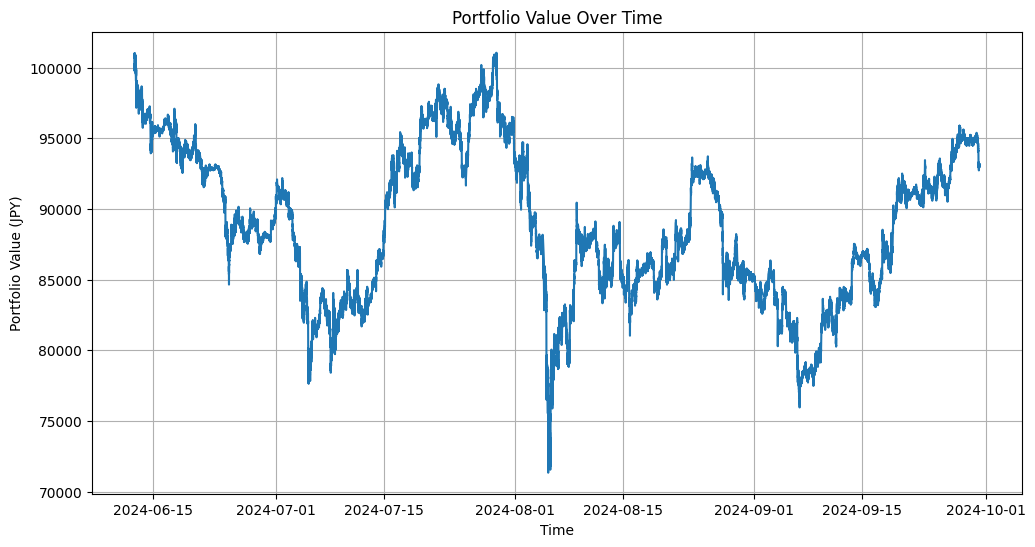

Total Return: -6.83%


In [34]:
# テストデータに予測結果を追加
df_test = df.iloc[split_index:].copy()
df_test['Predicted_Signal'] = y_pred

# 初期資金とポジションの設定
initial_capital = 100000  # 初期資金10万円
position = 0  # ポジション（1:買い、-1:売り、0:なし）
cash = initial_capital
portfolio_value = []

# バックテストの実行
for i in range(len(df_test)):
    signal = df_test['Predicted_Signal'].iloc[i]
    price = df_test['Close'].iloc[i]
    
    # 購入シグナル
    if signal == 1 and position == 0:
        position = cash / price  # 全額で購入
        cash = 0
    # 売却シグナル
    elif signal == -1 and position > 0:
        cash = position * price  # 全額売却
        position = 0
    # ホールド
    else:
        pass  # 何もしない
    
    # 現在のポートフォリオ価値を計算
    total_asset = cash + position * price
    portfolio_value.append(total_asset)

# ポートフォリオ価値の時系列データを作成
df_test['Portfolio_Value'] = portfolio_value

# 結果のプロット
plt.figure(figsize=(12,6))
plt.plot(df_test.index, df_test['Portfolio_Value'])
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value (JPY)')
plt.grid(True)
plt.show()

# パフォーマンスの評価
total_return = (df_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
print(f"Total Return: {total_return:.2f}%")

In [35]:
# 訓練済みのモデルから特徴量重要度を取得
importances = best_model.feature_importances_

# 特徴量名と重要度をデータフレームにまとめる
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# 重要度の高い順にソート
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# 結果の表示
print(feature_importance_df)

           Feature  Importance
12             ATR    0.441629
21  Pct_Volatility    0.132893
13       ATR_Upper    0.079000
14       ATR_Lower    0.045773
0         MA_short    0.041533
3       Lower_Band    0.035079
5             MACD    0.034289
1          MA_long    0.029406
2       Upper_Band    0.022977
6      Signal_Line    0.021283
7    Volume_Change    0.019760
19  MA_short_Slope    0.018616
8     Price_Change    0.016488
11             CCI    0.008824
20             OBV    0.008001
4              RSI    0.007735
22  Price_Position    0.007483
9    Stochastic_%K    0.006742
10   Stochastic_%D    0.004869
16        RSI_Lag5    0.004838
17       RSI_Lag10    0.004741
15        RSI_Lag1    0.004621
18     MACD_Volume    0.003418


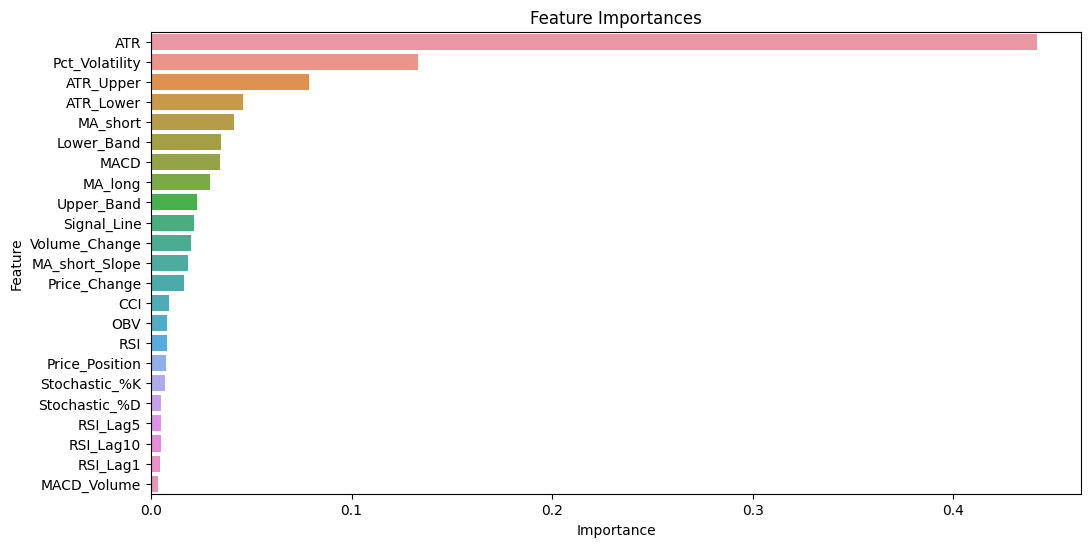

In [36]:
# 可視化のためのライブラリをインポート
import matplotlib.pyplot as plt
import seaborn as sns

# 棒グラフで特徴量重要度を表示
plt.figure(figsize=(12,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

In [37]:
# 上位10個の特徴量を選択
top_features = feature_importance_df['Feature'].head(10).tolist()

print("Selected Top Features:\n", top_features)

Selected Top Features:
 ['ATR', 'Pct_Volatility', 'ATR_Upper', 'ATR_Lower', 'MA_short', 'Lower_Band', 'MACD', 'MA_long', 'Upper_Band', 'Signal_Line']


In [38]:
# 選択した特徴量のみを使用
X = df[top_features]
y = df['Target']

# データの分割（前回と同じ）
split_ratio = 0.7
split_index = int(len(df) * split_ratio)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# 特徴量の標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# モデルの再訓練（ハイパーパラメータは前回の最適値を使用）
best_params = grid_search.best_params_

# 新しいXGBoostモデルの初期化
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    **best_params
)

# モデルの訓練
xgb_model.fit(X_train_scaled, y_train)

# テストデータでの予測
y_pred = xgb_model.predict(X_test_scaled)

# モデルの評価
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.00      0.00     42427
           1       0.62      0.81      0.70     60721
           2       0.50      0.72      0.59     54788

    accuracy                           0.56    157936
   macro avg       0.48      0.51      0.43    157936
weighted avg       0.49      0.56      0.47    157936

Confusion Matrix:
 [[   49 14785 27593]
 [   62 49105 11554]
 [   47 15547 39194]]


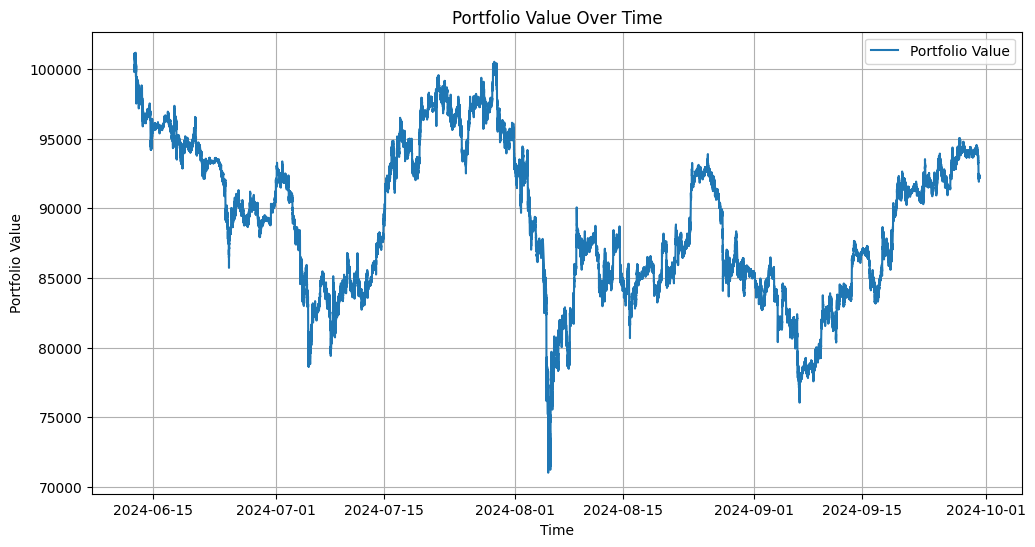

Total Return: -7.65%


In [39]:
# テストデータに予測結果を追加
df_test = df.iloc[split_index:].copy()
df_test['Predicted_Signal'] = y_pred

# 初期資金とポジションの設定（前回と同じ）
initial_capital = 100000  # 初期資金10万円
position = 0  # ポジション（数量）
cash = initial_capital
portfolio_value = []

# バックテストの実行（前回と同じ）
for i in range(len(df_test)):
    signal = df_test['Predicted_Signal'].iloc[i]
    price = df_test['Close'].iloc[i]
    
    # 買いシグナル（ラベル2）
    if signal == 2 and position == 0:
        position = cash / price  # 全額で購入
        cash = 0
    # 売りシグナル（ラベル0）
    elif signal == 0 and position > 0:
        cash = position * price  # 全額売却
        position = 0
    # ホールド（ラベル1）または他の場合
    else:
        pass  # 何もしない
    
    # 現在のポートフォリオ価値を計算
    total_asset = cash + position * price
    portfolio_value.append(total_asset)

# ポートフォリオ価値の時系列データを作成
df_test['Portfolio_Value'] = portfolio_value

# 結果のプロット
plt.figure(figsize=(12,6))
plt.plot(df_test.index, df_test['Portfolio_Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

# パフォーマンスの評価
total_return = (df_test['Portfolio_Value'].iloc[-1] - initial_capital) / initial_capital * 100
print(f"Total Return: {total_return:.2f}%")